In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from random import choices

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC

# Cleaning function

#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text

# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove

#Remove stopwords & Punctuations
def remove_stopwords(text,STOPWORDS):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
    
def remove_punct(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct

def clean_text(text):

    STOPWORDS = set(stopwords.words('english'))

    cleaned = remove_urls(text) # Remove Urls
    cleaned = remove_html(cleaned) # Remove HTML links
    cleaned = remove_punct(cleaned) # Remove Punctuations
    cleaned = lower(cleaned) # Lower casing
    cleaned = remove_num(cleaned) # Remove numbers
    cleaned = remove_stopwords(cleaned,STOPWORDS) # Remove stopwords

    return cleaned

In [2]:
df = pd.read_csv('data/reviews.csv').fillna('') # Reads csv with data
df.rename({'Recommended IND':'Recommended'}, axis=1, inplace=True) # Rename column 
df['Review'] = df['Title'] + ' ' + df['Review Text'] # Concatenate title and review text

df = df[['Recommended', 'Review']]

print('Number of empty reviews:')
print(df['Review'].apply(lambda x: len(x)==0).sum())
print('\nNumber of 0 and 1 in Recommended :')
print(df['Recommended'].value_counts())

# Before anything, let's split into test and train data.

X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Recommended'], test_size=0.25, random_state=27)

Number of empty reviews:
0

Number of 0 and 1 in Recommended :
1    19314
0     4172
Name: Recommended, dtype: int64


In [3]:
# Gather X_train and X_test into a dataframe
df_X = pd.concat([X_train, y_train], axis=1)

df_majority = df_X[(df_X['Recommended']==1)]
df_minority = df_X[(df_X['Recommended']==0)]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=len(df_majority) , # to match majority class
                                 random_state=42)  # reproducible results
                                 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

Text(0.5, 0.98, 'Avant upsampling')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


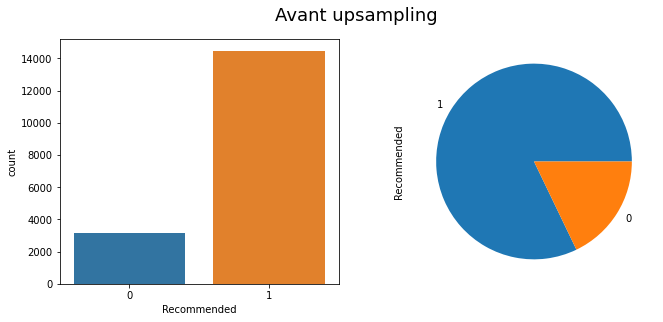

In [4]:
# Uneven distribution of reviews

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

fig = plt.figure(figsize = (11, 4.5))
plt.subplot(1, 2, 1)
sns.countplot(x=df_X['Recommended'])

plt.subplot(1, 2, 2)
df_X['Recommended'].value_counts().plot.pie(y='Class')
fig.suptitle('Avant upsampling', fontsize=18)

Text(0.5, 0.98, 'Après upsampling')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


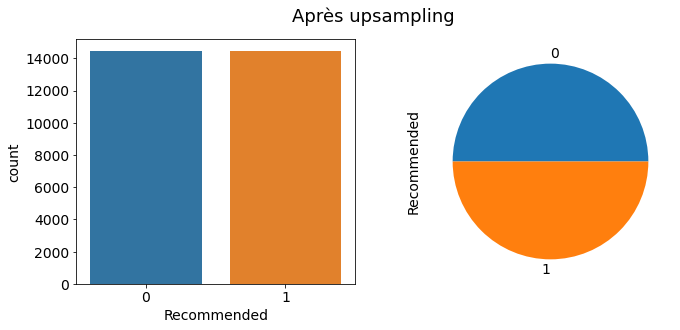

In [5]:
# Even distribution of reviews in our test data set

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

fig = plt.figure(figsize = (11, 4.5))
plt.subplot(1, 2, 1)
sns.countplot(x=df_upsampled['Recommended'])

plt.subplot(1, 2, 2)
df_upsampled['Recommended'].value_counts().plot.pie(y='Class')
fig.suptitle('Après upsampling', fontsize=18)

In [6]:
# Apply cleaning process to reviews : keep only meaningful words 

df_upsampled.reset_index(drop=True, inplace=True)
df_upsampled['Review'] = df_upsampled['Review'].apply(clean_text)

X_train = df_upsampled['Review']
y_train = df_upsampled['Recommended']

count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vec.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [11]:
X_test_tfidf

<5872x16231 sparse matrix of type '<class 'numpy.float64'>'
	with 149630 stored elements in Compressed Sparse Row format>

In [75]:
###################### SGDClassifier ######################

losses = ['hinge','log_loss']
max_iters = [1,2,3,4,5,10,12,15,20,25,30,40,50]
penalties = ['l1','l2']

r = []

for loss in losses:

    for max_iter in max_iters:

        for penalty in penalties:

            r_i = {}

            clf = SGDClassifier(loss=loss, penalty=penalty, max_iter=max_iter, tol=None)
            start = time.time()
            clf.fit(X_train_tfidf, y_train)
            stop = time.time()
            y_pred = clf.predict(X_test_tfidf)

            r_i['loss'] = loss
            r_i['max_iter'] = max_iter
            r_i['penalty'] = penalty

            r_i['accuracy'] = accuracy_score(y_test, y_pred)
            r_i['recall'] = recall_score(y_test, y_pred)
            r_i['precision'] = precision_score(y_test, y_pred)
            r_i['f1'] = f1_score(y_test, y_pred)
            r_i['time'] = stop - start

            r.append(r_i)

df_r = pd.DataFrame.from_dict(r)

df_hinge = df_r.loc[df_r['loss']=='hinge']
df_log_loss = df_r.loc[df_r['loss']=='log_loss']

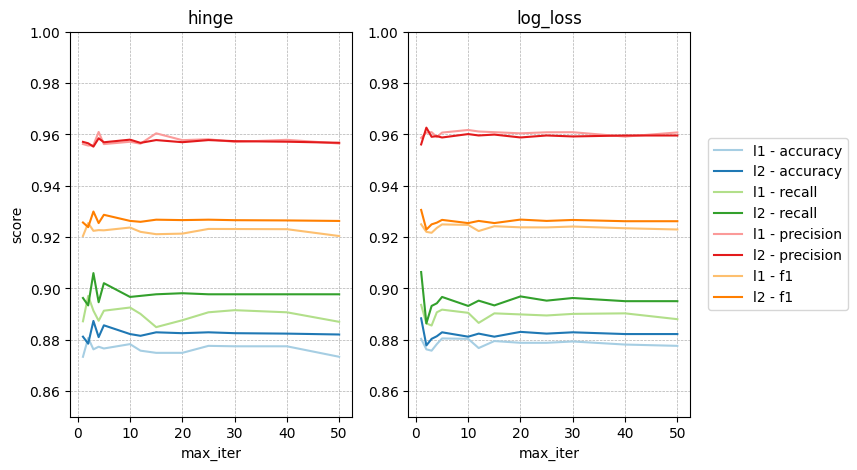

In [94]:
# hinge

legends = []

plt.figure(figsize=[8,5])
plt.subplot(1,2,1)
sns.set_palette("Paired")

for y in ['accuracy','recall','precision','f1'] :
    for penalty in penalties:
        df_i = df_hinge.loc[df_hinge['penalty']==penalty,['max_iter',y]]

        sns.lineplot(x='max_iter',y=y, data=df_i)

        legends.append(penalty+' - '+y)

plt.ylim([0.85,1])
plt.ylabel('score')
plt.title('hinge')
plt.grid(linestyle = '--', linewidth = 0.5)


# log_loss

legends = []

plt.subplot(1,2,2)
sns.set_palette("Paired")

for y in ['accuracy','recall','precision','f1'] :
    for penalty in penalties:
        df_i = df_log_loss.loc[df_log_loss['penalty']==penalty,['max_iter',y]]

        sns.lineplot(x='max_iter',y=y, data=df_i)

        legends.append(penalty+' - '+y)

plt.ylim([0.85,1])
plt.ylabel('')
plt.title('log_loss')
plt.grid(linestyle = '--', linewidth = 0.5)

plt.legend(legends,bbox_to_anchor=(1.04, 0.5), loc="center left")



In [79]:
###################### RandomForestClassifier ######################

n_estimatorss = [1, 2, 4, 8, 16, 32, 64, 100]

r = []

for n_estimators in n_estimatorss :

    r_i = {}

    clf = RandomForestClassifier(n_estimators=n_estimators)
    start = time.time()
    clf.fit(X_train_tfidf, y_train)
    stop = time.time()
    y_pred = clf.predict(X_test_tfidf)
    
    r_i['n_estimators'] = n_estimators

    r_i['accuracy'] = accuracy_score(y_test, y_pred)
    r_i['recall'] = recall_score(y_test, y_pred)
    r_i['precision'] = precision_score(y_test, y_pred)
    r_i['f1'] = f1_score(y_test, y_pred)
    r_i['time'] = stop - start

    r.append(r_i)

df_r = pd.DataFrame.from_dict(r)

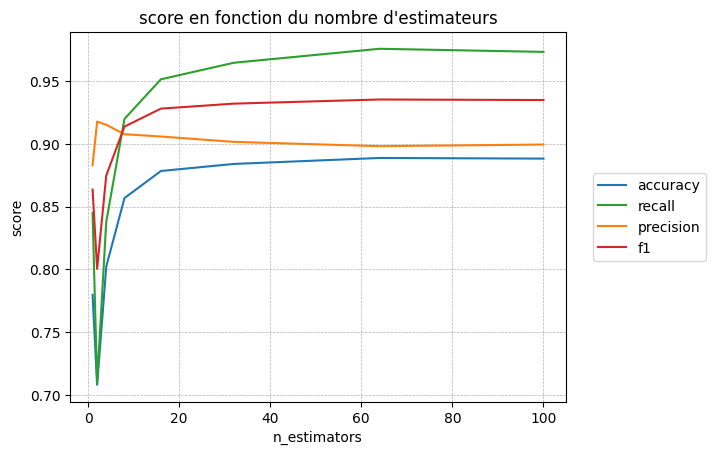

In [92]:
colors = ["tab:blue", "tab:green","tab:orange","tab:red"]

plt.figure()
sns.set_palette(sns.color_palette(colors))

legends = []

for y in ['accuracy','recall','precision','f1'] :

    sns.lineplot(x='n_estimators',y=y, data=df_r)

    legends.append(y)

plt.grid(linestyle = '--', linewidth = 0.5)
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.title('score en fonction du nombre d\'estimateurs')
plt.legend(legends,bbox_to_anchor=(1.04, 0.5), loc="center left")

In [101]:
import numpy as np

max_depths = range(1,30)

r = []

for max_depth in max_depths :

    r_i = {}

    clf = RandomForestClassifier(n_estimators=60, max_depth=int(max_depth))
    start = time.time()
    clf.fit(X_train_tfidf, y_train)
    stop = time.time()
    y_pred = clf.predict(X_test_tfidf)
    
    r_i['max_depth'] = max_depth

    r_i['accuracy'] = accuracy_score(y_test, y_pred)
    r_i['recall'] = recall_score(y_test, y_pred)
    r_i['precision'] = precision_score(y_test, y_pred)
    r_i['f1'] = f1_score(y_test, y_pred)
    r_i['time'] = stop - start

    r.append(r_i)

df_r = pd.DataFrame.from_dict(r)

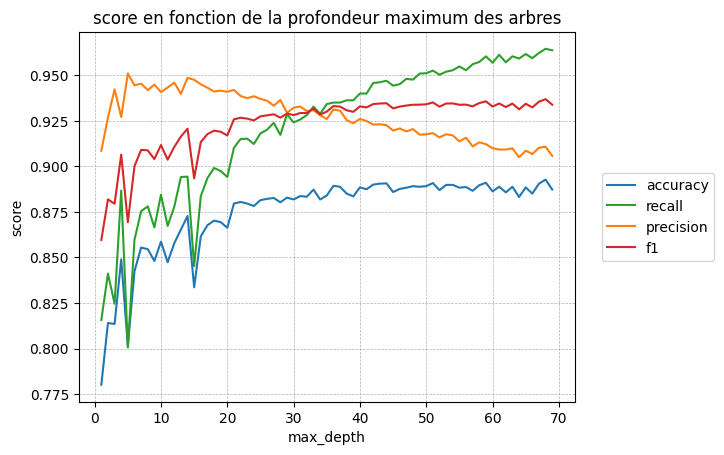

In [102]:
colors = ["tab:blue", "tab:green","tab:orange","tab:red"]

plt.figure()
sns.set_palette(sns.color_palette(colors))

legends = []

for y in ['accuracy','recall','precision','f1'] :

    sns.lineplot(x='max_depth',y=y, data=df_r)

    legends.append(y)

plt.grid(linestyle = '--', linewidth = 0.5)
plt.ylabel('score')
plt.xlabel('max_depth')
plt.title('score en fonction de la profondeur maximum des arbres')
plt.legend(legends,bbox_to_anchor=(1.04, 0.5), loc="center left")

In [10]:
X_train = df_upsampled['Review']
y_train = df_upsampled['Recommended']

count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vec.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

print('SGDClassifier')
clf = SGDClassifier(loss='log_loss', penalty='l2', max_iter=30)
start = time.time()
clf.fit(X_train_tfidf, y_train)
stop = time.time()
y_pred = clf.predict(X_test_tfidf)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Training time: {} s'.format(stop - start))
print('\n')

print('RandomForestclassifier')
clf = RandomForestClassifier(n_estimators=50, max_depth=35)
start = time.time()
clf.fit(X_train_tfidf, y_train)
stop = time.time()
y_pred = clf.predict(X_test_tfidf)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Training time: {} s'.format(stop - start))
print('\n')

print('LinearSVC')
clf = LinearSVC(loss='hinge', penalty='l2')
start = time.time()
clf.fit(X_train_tfidf, y_train)
stop = time.time()
y_pred = clf.predict(X_test_tfidf)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Training time: {} s'.format(stop - start))


SGDClassifier
Accuracy: 0.8838555858310627
Recall: 0.8984729673957903
Precision: 0.9581866197183099
F1 score: 0.9273695420660277
Training time: 0.06500005722045898 s


RandomForestclassifier
Accuracy: 0.8864100817438693
Recall: 0.9329343788691704
Precision: 0.9296730413325108
F1 score: 0.9313008548769184
Training time: 7.200720310211182 s


LinearSVC
Accuracy: 0.8826634877384196
Recall: 0.9104416013206769
Precision: 0.9453610456395972
F1 score: 0.927572795122464
Training time: 0.28043699264526367 s


In [200]:
# Before anything, let's split into test and train data.

df['Review'] = df['Review'].apply(clean_text)
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Recommended'], test_size=0.25, random_state=27)

# Gather X_train and X_test into a dataframe
df_train = pd.concat([X_train, y_train], axis=1)

df_majority = df_train[(df_train['Recommended']==1)]
df_minority = df_train[(df_train['Recommended']==0)]

n_classifiers = 100
list_classifiers = []
list_preds = []

# Training 

start = time.time()
for i in range(n_classifiers):

    # Partitionning
    list_choices = choices(df_majority.index, k=len(df_minority))

    df_majority_downsampled = df_majority.loc[list_choices]

    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    X_train = df_downsampled['Review']
    y_train = df_downsampled['Recommended']

    count_vec = CountVectorizer()
    X_train_counts = count_vec.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

    X_test_counts = count_vec.transform(X_test)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    
    clf = LinearSVC()
    clf.fit(X_train_tfidf, y_train)
    list_classifiers.append(clf)

    y_pred = clf.predict(X_test_tfidf)
    list_preds.append(y_pred)


stop = time.time()

# y_pred = evclf.predict(X_test_tfidf)
# print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
# print('Recall: {}'.format(recall_score(y_test, y_pred)))
# print('Precision: {}'.format(precision_score(y_test, y_pred)))
# print('F1 score: {}'.format(f1_score(y_test, y_pred)))
# print('Training time: {} s'.format(stop - start))

In [201]:
df_preds = pd.DataFrame.from_records(list_preds)
pred_array = []

for col in df_preds.columns :
    pred_array.append(df_preds[col].value_counts().idxmax())



In [202]:
y_pred = pred_array
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Training time: {} s'.format(stop - start))

Accuracy: 0.8664850136239782
Recall: 0.8689640940982254
Precision: 0.9658256880733945
F1 score: 0.9148381490332392
Training time: 16.730302095413208 s


# LAST

In [7]:
X_train = df_upsampled['Review']
y_train = df_upsampled['Recommended']

count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vec.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

print('SGDClassifier')
clf = SGDClassifier(loss='log_loss', penalty='l2', max_iter=30)
start = time.time()
clf.fit(X_train_tfidf, y_train)
stop = time.time()
y_pred = clf.predict(X_test_tfidf)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Training time: {} s'.format(stop - start))
print('\n')

SGDClassifier
Accuracy: 0.8821525885558583
Recall: 0.894758563763929
Precision: 0.9597166888003541
F1 score: 0.9260999572832124
Training time: 0.03917884826660156 s




In [31]:
text = "Super comfy I've read the previous reviews about this dress and was hesitant to order it but i'm so happy i did! i can definitely understand why certain reviews are saying that the fabric is cheap. it is an extremely thin material as well as a thin lining.  however i think it depends on the person. because neither of those things actually bother me. i get hot very easily so i appreciate the fact that this dress is very thin and flowy.  i think it's extremely comfortable and looks very cute on.  the zipper d"

text = clean_text(text)
print(text)
text_count = count_vec.transform([text])
text_tfidf = tfidf_transformer.transform(text_count)
clf.predict(text_tfidf)[0]

super comfy ive read previous reviews dress hesitant order im happy definitely understand certain reviews saying fabric cheap extremely thin material well thin lining however think depends person neither things actually bother get hot easily appreciate fact dress thin flowy think extremely comfortable looks cute zipper


0

In [37]:
0

0

In [9]:
import pickle

filename = 'model_saved'

with open(filename, 'wb') as fout:
    pickle.dump((count_vec, tfidf_transformer, clf), fout)

import pickle

with open('model_saved', 'rb') as f:
    count_vec, tfidf_transformer, clf = pickle.load(f)

In [19]:
text = " i hate it, don't buy it"

text = clean_text(text)
print(text)
text_count = count_vec.transform([text])
text_tfidf = tfidf_transformer.transform(text_count)
clf.predict(text_tfidf)[0]

hate dont buy


1